### **SETUP & IMPORTS**

In [ ]:
!pip install import-ipynb
!pip install biopython==1.84

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 5.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score,
    precision_recall_curve,
    auc,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
from sklearn.base import BaseEstimator, TransformerMixin, clone
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import warnings
import import_ipynb
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import os

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Import all variables from the module 'Features_extraction_SVM'
from Features_extraction_SVM import *

Saving neg_train.tsv to neg_train.tsv
Saving negative.fasta to negative.fasta
Saving pos_train.tsv to pos_train.tsv
Saving positive.fasta to positive.fasta


Streaming output truncated to the last 5000 lines.


Feature matrix shape: (8021, 29)
Feature names: ['hydro_max', 'hydro_mean', 'charge_max', 'charge_mean', 'alpha_max', 'alpha_mean', 'trans_max', 'trans_mean', 'size_max', 'size_mean', 'comp_G', 'comp_A', 'comp_V', 'comp_L', 'comp_I', 'comp_M', 'comp_F', 'comp_W', 'comp_Y', 'comp_S', 'comp_T', 'comp_C', 'comp_N', 'comp_Q', 'comp_H', 'comp_D', 'comp_E', 'comp_K', 'comp_R']

Feature extraction completed successfully.
File saved as: ML_features.tsv
Total samples: 8021, Total features: 29


### **DATA PREPARATION**
Check that feature and label variables exist, then convert them to NumPy arrays for consistent processing.


In [ ]:
# Confirm X,y exist
try:
    X
    y
except NameError:
    raise RuntimeError("Please provide X and y variables (features and labels) before running this script.")

# Convert input data to NumPy arrays for consistent handling
if isinstance(X, pd.DataFrame):
    # If X is a pandas DataFrame, extract column names and values
    feature_names = X.columns.to_numpy()
    X_arr = X.values
else:
    # If X is already a NumPy array (no column names available)
    X_arr = np.asarray(X)
    feature_names = np.array([f"f{i}" for i in range(X_arr.shape[1])])

# Convert y to a NumPy array
y_arr = np.asarray(y).ravel()

print(f"Data shape: X={X_arr.shape}, y={y_arr.shape}, positive_count={np.sum(y_arr==1)}")


Data shape: X=(8021, 29), y=(8021,), positive_count=874


### **TRAIN-VALIDATION SPLIT**

- Split the selected features and target labels into training, validation and test sets.  

- Use 80% of the data for training (25% as validation set) and 20% for validation.  

- Apply stratification to preserve the class distribution in both sets.  

- This allows us to train the model and evaluate its performance on unseen data.



In [ ]:
# Split the data into training, validation and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

# Print the shape of the created sets
print(f"Train shape: {X_train.shape}, Validation shape {X_val.shape} Test shape: {X_test.shape}")


Train shape: (4812, 29), Validation shape (1604, 29) Test shape: (1605, 29)


### **DEFINE PIPELINE**
Construct a full machine learning pipeline combining preprocessing, feature selection, class balancing, and classification.

Unlike the standard scikit-learn pipeline, an imbalanced-learn pipeline supports resampling techniques such as SMOTE to address class imbalance directly within the training process.  

In [ ]:
# Select the most important features based on Random Forest importances
rf_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    threshold="median"
)

# Build an imbalanced-learn pipeline
pipeline = ImbPipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("feature_selection", rf_selector),
        ("smote", SMOTE(random_state=42)),
        ("svc", SVC(probability=True, random_state=42))
    ]
)

### **SVM HYPERPARAMETER TUNING WITH GRID SEARCH**

- Explore different combinations of hyperparameters (`C`, `kernel`, `gamma`).
  - `C`: `[0.1, 1, 10]` — Regularization parameter controlling the trade-off between margin width and classification error.  
  - `kernel`: `['linear', 'poly', 'rbf', 'sigmoid']` — Specifies the kernel type to transform data (linear, polynomial, radial basis function, sigmoid).  
  - `gamma`: `['scale', 'auto']` — Kernel coefficient for ‘rbf’, ‘poly’, and ‘sigmoid’ kernels, affecting the influence of single training examples.

- Use 5-fold stratified cross-validation to evaluate each combination.  
- Select the parameters that achieve the highest accuracy, optimizing model performance.


In [ ]:
# Define parameter grid for SVM
param_grid = {
    "svc__C": [0.1, 1, 10],
    "svc__kernel": ["linear", "rbf"],
    "svc__gamma": ["scale", "auto"]
}

# Initialize stratified 5-fold cross-validation to ensure equal class distribution in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define grid search to tune hyperparameters using 5-fold cross-validation
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring="f1",
    n_jobs=-1,
    cv=cv,
    verbose=1
)

### **TRAIN THE MODEL**

Perform hyperparameter optimization with GridSearchCV using 5-fold cross-validation, then evaluate the best model on the validation set.

In [ ]:
# Perform cross-validation to find the best hyperparameters and fit the final model
grid.fit(X_train, y_train)

# Print the best parameter combination and the corresponding cross-validation F1 score
print("Best params:", grid.best_params_)
print("Best CV F1:", round(grid.best_score_, 4))

# Retrieve the best-performing model from the grid search
best_model = grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best CV F1: 0.7205


In [ ]:
# Evaluate model performance on the validation set
best_svm = grid.best_estimator_
val_pred = best_svm.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)

print("Validation accuracy:", val_acc)

Validation accuracy: 0.922069825436409


### **FINAL EVALUATION OF BEST SVM MODEL**

- Evaluate the best SVM model on the full dataset.  
- Compute key performance metrics:
  - Accuracy
  - Precision
  - Recall
  - F1-score
  - MCC  
- Plot the **Confusion Matrix**  and the **Precision-Recall curve**  
- Generate a detailed **classification report** for positive and negative classes.  
- Save the final metrics to a **TSV file** for record-keeping and further analysis.



 Final Evaluation on Test Dataset
---------------------------------------------
Accuracy:   0.927
Precision:  0.620
Recall:     0.857
F1-score:   0.719
MCC:        0.691
---------------------------------------------

 TEST METRICS
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1430
           1       0.62      0.86      0.72       175

    accuracy                           0.93      1605
   macro avg       0.80      0.90      0.84      1605
weighted avg       0.94      0.93      0.93      1605



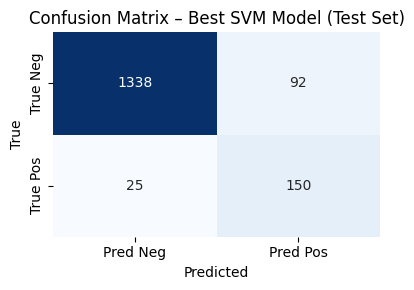

--------------------------------------------------------------------------------


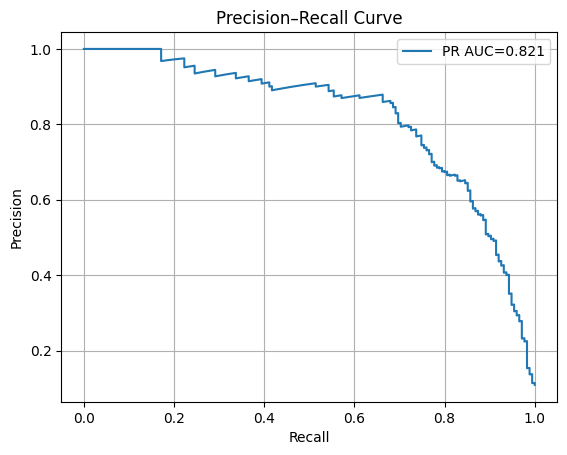


 Metrics saved to 'training_svm_metrics.tsv'


In [ ]:
# Predict discrete class labels and probability scores for the positive class (1)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute main performance metrics on the test set
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Display results
print("\n Final Evaluation on Test Dataset")
print("-" * 45)
print(f"Accuracy:   {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall:     {rec:.3f}")
print(f"F1-score:   {f1:.3f}")
print(f"MCC:        {mcc:.3f}")
print("-" * 45)

print("\n TEST METRICS")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Neg','Pred Pos'], yticklabels=['True Neg','True Pos'])
plt.title("Confusion Matrix – Best SVM Model (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
print('-' * 80)

# Plot Precision–Recall curve and compute AUC
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"PR AUC={pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


# Save the metrics
metrics_dict = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "MCC": mcc
}


results_df = pd.DataFrame([metrics_dict])
results_file_path = 'training_svm_metrics.tsv'
results_df.to_csv(results_file_path, sep="\t", index=False)

print(f"\n Metrics saved to '{results_file_path}'")




In [ ]:
mask = best_model.named_steps["feature_selection"].get_support()
print(f"Selected {mask.sum()} / {mask.shape[0]} features.")

Selected 15 / 29 features.


### **VISUALIZING FEATURE IMPORTANCE**

- Focus on biophysical features (e.g., hydrophobicity, charge, size, alpha-helix propensity, transmembrane regions) from the selected features
  
- Retrieve their Gini importance scores from the trained Random Forest.

- Sort and display the top features to understand which biophysical properties contribute most to the model.  

- Visualize the top 10 features with a horizontal bar plot for clear interpretation.



Features ordered by Gini importance:
        feature  importance
12       comp_L    0.186715
5    alpha_mean    0.082611
3   charge_mean    0.061602
6     trans_max    0.054907
0     hydro_max    0.048768
4     alpha_max    0.047207
1    hydro_mean    0.042777
9     size_mean    0.041182
7    trans_mean    0.040567
13       comp_E    0.035854


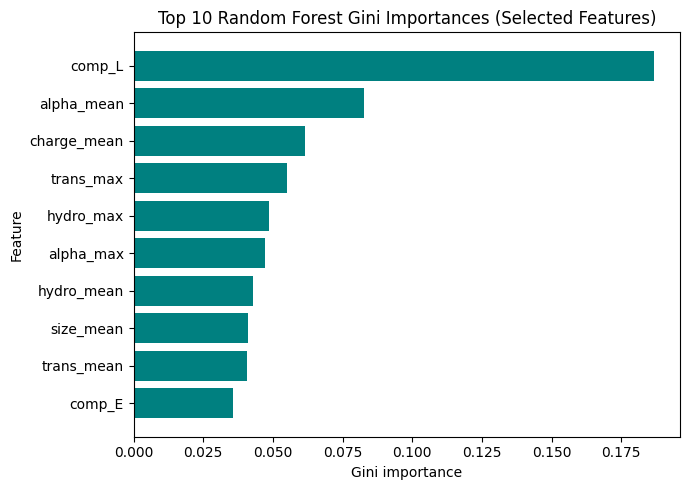

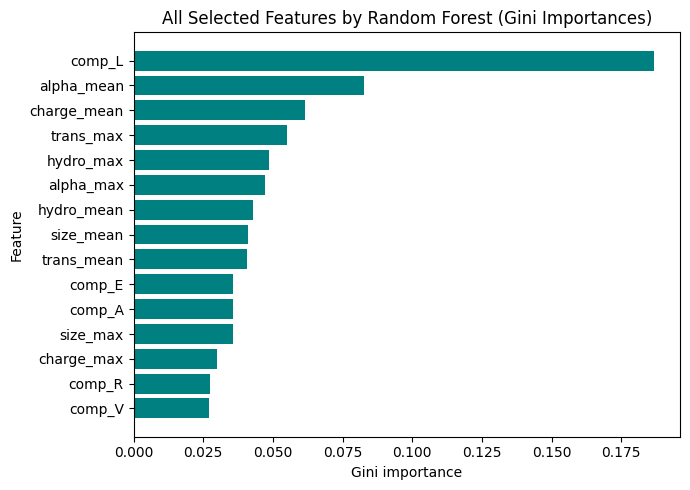

In [ ]:
# Retrieve features selected by the Random Forest feature selector
rf_model = best_model.named_steps["feature_selection"].estimator_
importances = rf_model.feature_importances_
mask = best_model.named_steps["feature_selection"].get_support()

# Map the boolean mask to the original column names
selected_features = np.array(X.columns)[mask]

# Build a DataFrame listing the selected features ranked by Gini importance
gini_df = pd.DataFrame({
    "feature": selected_features,
    "importance": importances[mask]
}).sort_values(by="importance", ascending=False)

print("\nFeatures ordered by Gini importance:")
print(gini_df.head(10))

# Plot the top 10 selected features
plt.figure(figsize=(7,5))
top10 = gini_df.head(10).iloc[::-1]
plt.barh(top10["feature"], top10["importance"], color='teal')
plt.xlabel("Gini importance")
plt.ylabel("Feature")
plt.title("Top 10 Random Forest Gini Importances (Selected Features)")
plt.tight_layout()
plt.show()

# Plot all features
plt.figure(figsize=(7,5))
top_all = gini_df.iloc[::-1]
plt.barh(top_all["feature"], top_all["importance"], color='teal')
plt.xlabel("Gini importance")
plt.ylabel("Feature")
plt.title("All Selected Features by Random Forest (Gini Importances)")
plt.tight_layout()
plt.show()


### **EVALUATING SVM ACCURACY ON TOP FEATURES**

- Assess how SVM performance changes when using only the top `k` features ranked by Random Forest Gini importance.  

- Iterate over a range of `k` values to find the optimal number of features that maximizes validation accuracy.  

- Use the best SVM parameters found from GridSearchCV for consistency.  

- Plot validation accuracy against `k` to visualize the effect of feature selection.


Best k on validation (using baseline best params): k=15, val_acc=0.922


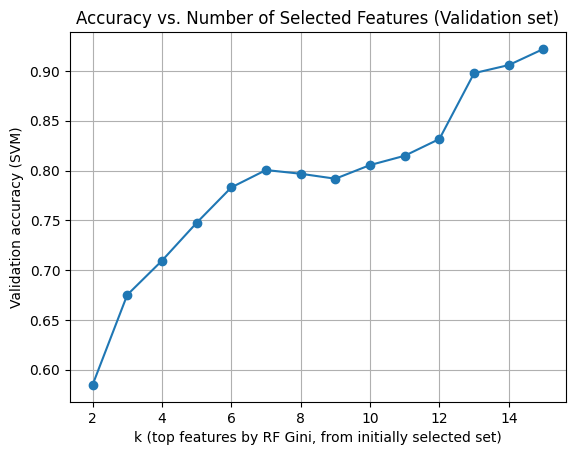

In [ ]:
# Extract components from the trained pipeline
scaler = best_model.named_steps["scaler"]
rf_selector = best_model.named_steps["feature_selection"]
smote_transformer = best_model.named_steps["smote"]

# Scale training and validation data using the fitted scaler
X_train_scaled_full = scaler.transform(X_train)
X_val_scaled_full = scaler.transform(X_val)

# Apply the same Random Forest feature selection used in the pipeline to obtain the filtered data subsets
X_train_initial_selected = rf_selector.transform(X_train_scaled_full)
X_val_initial_selected = rf_selector.transform(X_val_scaled_full)

# Get the names of the selected feaures
selected_feature_names_ordered = gini_df['feature'].tolist()

# Compute validation accuracy using the top k most important features
def accuracy_on_subset_optimized(k_features, X_train_data, y_train_data, X_val_data, y_val_data, C, gamma):
    Xtr_k = X_train_data[:, :k_features]
    Xva_k = X_val_data[:, :k_features]

    # Resample selected training data with SMOTE
    Xtr_k_smoted, y_train_smoted = smote_transformer.fit_resample(Xtr_k, y_train_data)

    # Train and evaluate a new SVC model with the best hyperparameters
    svc_model = SVC(C=C, gamma=gamma, random_state=42) # Keep random_state for reproducibility
    svc_model.fit(Xtr_k_smoted, y_train_smoted)
    return svc_model.score(Xva_k, y_val_data)

# Get the best hyperparameters from the GridSearchCV result
best_svc_C = grid.best_params_["svc__C"]
best_svc_gamma = grid.best_params_["svc__gamma"]

# Compute validation accuracy by varying the number of features (k) using the best hyperparameters
max_features_available = X_train_initial_selected.shape[1]
ks = list(range(2, max_features_available + 1))
curve = []

for k in ks:
    acc_k = accuracy_on_subset_optimized(
        k,
        X_train_initial_selected,
        y_train,
        X_val_initial_selected,
        y_val,
        best_svc_C,
        best_svc_gamma
    )
    curve.append(acc_k)

# Find the best k and plot validation accuracy
best_k_idx = int(np.argmax(curve))
best_k = ks[best_k_idx]
print(f"Best k on validation (using baseline best params): k={best_k}, val_acc={curve[best_k_idx]:.3f}")

plt.figure()
plt.plot(ks, curve, marker="o")
plt.xlabel("k (top features by RF Gini, from initially selected set)")
plt.ylabel("Validation accuracy (SVM)")
plt.title("Accuracy vs. Number of Selected Features (Validation set)")
plt.grid(True)
plt.show()

### **PROCESS BENCHMARK DATA**

Apply the same feature extraction, scaling, and feature selection steps to the benchmark dataset (`test_df`).

In [ ]:
# Load positive and negative benchmark files
col_pos_bench = ['seq_id', 'class', 'Organism', 'Kingdom', 'Sequence_length','SP cleavage']
col_neg_bench = ['seq_id', 'class', 'Organism', 'Kingdom', 'Sequence_length', 'N-term transmembrane']
pos_bench = pd.read_csv('pos_bench.tsv', sep='\t', header=None, names=col_pos_bench)
neg_bench = pd.read_csv('neg_bench.tsv', sep='\t', header=None, names=col_neg_bench)

# Create a custom file for positives sequences
with open('positive.fasta', 'r') as read:
  with open('svm_pos_test.tsv', 'w') as write:
    for line in read:
      if '>' in line:
        line = line[1:].rstrip()
        query = pos_bench.query("seq_id == @line")
        if not query.empty:
          line = read.readline()
          print(query['seq_id'].iloc[0]+'\t1\t'+line.rstrip()[:90], file=write)

# Create a custom file for negatives sequences
with open('negative.fasta', 'r') as read:
  with open('svm_neg_test.tsv', 'w') as write:
    for line in read:
      if '>' in line:
        line = line[1:].rstrip()
        query = neg_bench.query("seq_id == @line")
        if not query.empty:
          line = read.readline()
          print(query['seq_id'].iloc[0]+'\t0\t'+line.rstrip()[:90], file=write)


# Save positive and negative TSV files into dataframes
col_test = ['seq_id', 'class', 'sequence']
pos_test = pd.read_csv('svm_pos_test.tsv', sep='\t', header=None, names=col_test)
neg_test = pd.read_csv('svm_neg_test.tsv', sep='\t', header=None, names=col_test)

In [ ]:
# Merge positive and negative files into a single dataframe
svm_df = pd.concat([pos_test,neg_test])
label_df = svm_df['class']

In [ ]:
# Extract sequence features for SVM classification
pos_features = extract_all(pos_test)
neg_features = extract_all(neg_test)

Streaming output truncated to the last 5000 lines.


In [ ]:
# Merge positive and negative features and remove sequence IDs
test_df = pd.concat([pos_features, neg_features], axis = 0)
test_df_noseq = test_df.drop(columns = ["seq_id"])
test_df_noseq

,hydro_max,hydro_mean,charge_max,charge_mean,alpha_max,alpha_mean,trans_max,trans_mean,size_max,size_mean,...,comp_S,comp_T,comp_C,comp_N,comp_Q,comp_H,comp_D,comp_E,comp_K,comp_R
0,3.48,0.050000,0.4,0.144444,1.336,1.012111,1.532,-0.309022,19.454,13.802244,...,0.136364,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909
1,3.00,-0.319556,0.6,0.095556,1.362,0.959644,1.256,-0.302311,19.538,14.581022,...,0.136364,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909
2,3.80,0.165333,0.4,0.122222,1.224,0.984578,1.820,-0.210467,21.400,15.717333,...,0.045455,0.000000,0.045455,0.000000,0.000000,0.090909,0.000000,0.045455,0.000000,0.000000
3,3.54,0.256667,0.4,0.077778,1.356,1.023467,1.562,-0.141222,20.010,14.736356,...,0.045455,0.045455,0.000000,0.000000,0.045455,0.000000,0.090909,0.000000,0.000000,0.000000
4,3.78,0.312889,0.4,0.084444,1.272,0.977267,1.726,-0.125756,21.080,15.182267,...,0.181818,0.045455,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.045455,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782,3.82,-0.030353,0.6,0.216471,1.214,0.953553,1.684,-0.188282,21.114,15.064824,...,0.090909,0.045455,0.045455,0.000000,0.000000,0.136364,0.000000,0.045455,0.090909,0.000000
1783,1.30,-1.590526,0.8,0.376316,1.196,0.951474,0.452,-0.972316,18.484,14.674289,...,0.090909,0.181818,0.000000,0.000000,0.090909,0.000000,0.000000,0.045455,0.272727,0.090909
1784,3.94,1.306222,0.4,0.066667,1.296,1.034067,1.850,0.428733,21.400,16.392067,...,0.045455,0.000000,0.045455,0.000000,0.000000,0.000000,0.045455,0.045455,0.000000,0.045455
1785,2.56,-0.448444,0.6,0.086667,1.258,1.001733,0.990,-0.628289,19.238,14.975422,...,0.090909,0.090909,0.000000,0.045455,0.000000,0.000000,0.090909,0.136364,0.136364,0.045455



 Final Evaluation on Benchmark Dataset
---------------------------------------------
Accuracy:   0.922
Precision:  0.594
Recall:     0.895
F1-score:   0.714
MCC:        0.690
---------------------------------------------

Detailed Classification Report (Benchmark Dataset):

              precision    recall  f1-score   support

    Negative       0.99      0.93      0.95      1787
    Positive       0.59      0.89      0.71       219

    accuracy                           0.92      2006
   macro avg       0.79      0.91      0.83      2006
weighted avg       0.94      0.92      0.93      2006



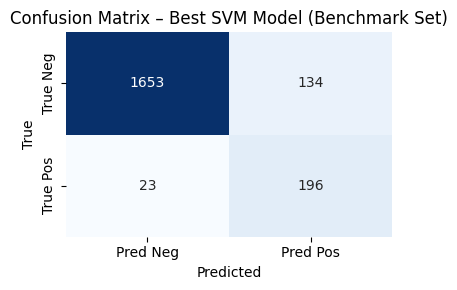


 Metrics saved to 'bench_svm_metrics.tsv'


In [ ]:
# Predict class labels on the benchmark dataset
y_pred_bench = best_model.predict(test_df_noseq)

# Compute main evaluation metrics
acc_bench = accuracy_score(label_df, y_pred_bench)
prec_bench = precision_score(label_df, y_pred_bench)
rec_bench = recall_score(label_df, y_pred_bench)
f1_bench = f1_score(label_df, y_pred_bench)
mcc_bench = matthews_corrcoef(label_df, y_pred_bench)

# Print performance summary and a more detailed classification report
print("\n Final Evaluation on Benchmark Dataset")
print("-" * 45)
print(f"Accuracy:   {acc_bench:.3f}")
print(f"Precision:  {prec_bench:.3f}")
print(f"Recall:     {rec_bench:.3f}")
print(f"F1-score:   {f1_bench:.3f}")
print(f"MCC:        {mcc_bench:.3f}")
print("-" * 45)

print("\nDetailed Classification Report (Benchmark Dataset):\n")
print(classification_report(label_df, y_pred_bench, target_names=["Negative", "Positive"]))

# Plot confusion matrix
cm_bench = confusion_matrix(label_df, y_pred_bench)
plt.figure(figsize=(4,3))
sns.heatmap(cm_bench, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Neg','Pred Pos'], yticklabels=['True Neg','True Pos'])
plt.title("Confusion Matrix – Best SVM Model (Benchmark Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Save metrics to TSV file
metrics_dict_bench = {
    "Accuracy": acc_bench,
    "Precision": prec_bench,
    "Recall": rec_bench,
    "F1": f1_bench,
    "MCC": mcc_bench
}

results_bench_df = pd.DataFrame([metrics_dict_bench])
results_bench_file_path = 'bench_svm_metrics.tsv'
results_bench_df.to_csv(results_bench_file_path, sep="\t", index=False)

print(f"\n Metrics saved to '{results_bench_file_path}'")

In [ ]:
# Remove first row (header) and reset index for merging
pos_bench_noheader = pos_bench.iloc[1:].reset_index(drop=True)
neg_bench_noheader = neg_bench.iloc[1:].reset_index(drop=True)

# Merge positive and negative benchmark data (original info)
svm_merge_tsv = pd.concat([pos_bench_noheader, neg_bench_noheader])
svm_merge_tsv = svm_merge_tsv.reset_index(drop=True)

# Merge original benchmark info with the extracted features from test_df
# test_df already contains 'seq_id' and all the feature columns
final_tsv = pd.merge(svm_merge_tsv, test_df, on='seq_id', how='inner')

# Add model predictions as a new column
final_tsv['Prediction'] = y_pred_bench

# Convert class labels to numeric format (1 = positive, 0 = negative)
# Note: 'class' column in svm_merge_tsv is 'positive'/'negative' strings
final_tsv['class'] = final_tsv['class'].map({'positive': 1, 'negative': 0}).astype(int)

TP = ((final_tsv['class'] == 1) & (final_tsv['Prediction'] == 1)).sum()
print('TP in Benchmark Data:', TP)

# Save final benchmark TSV
final_tsv.to_csv('svm_final.tsv', sep='\t', index=False)


TP in Benchmark Data: 196


In [ ]:
final_tsv

,seq_id,class,Organism,Kingdom,Sequence_length,SP cleavage,N-term transmembrane,hydro_max,hydro_mean,charge_max,...,comp_T,comp_C,comp_N,comp_Q,comp_H,comp_D,comp_E,comp_K,comp_R,Prediction
0,Q62598,1,Rattus norvegicus,Metazoa,687,17,NaN,3.34,-0.339556,0.4,...,0.090909,0.045455,0.000000,0.045455,0.000000,0.000000,0.000000,0.090909,0.000000,1
1,P67788,1,Manduca sexta,Metazoa,65,19,NaN,3.56,0.309846,0.4,...,0.090909,0.000000,0.000000,0.045455,0.000000,0.000000,0.045455,0.045455,0.000000,1
2,Q8TD06,1,Homo sapiens,Metazoa,166,21,NaN,3.62,-0.212222,0.8,...,0.045455,0.045455,0.045455,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,1
3,Q99372,1,Rattus norvegicus,Metazoa,870,27,NaN,4.02,0.555333,0.4,...,0.045455,0.000000,0.045455,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,P06865,1,Homo sapiens,Metazoa,529,22,NaN,3.00,-0.319556,0.6,...,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001,Q5SUQ9,0,Mus musculus,Metazoa,1212,NaN,False,3.44,-0.304222,0.6,...,0.090909,0.045455,0.000000,0.136364,0.000000,0.000000,0.090909,0.000000,0.045455,1
2002,Q10222,0,Schizosaccharomyces pombe (strain 972 / ATCC 2...,Fungi,670,NaN,False,2.70,-0.230667,0.6,...,0.136364,0.000000,0.045455,0.045455,0.045455,0.090909,0.136364,0.045455,0.090909,0
2003,Q9NUX5,0,Homo sapiens,Metazoa,634,NaN,False,3.28,0.174444,0.6,...,0.136364,0.000000,0.090909,0.045455,0.000000,0.000000,0.000000,0.045455,0.000000,0
2004,Q9BQ48,0,Homo sapiens,Metazoa,92,NaN,False,2.70,-0.521111,0.8,...,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0
